In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Selection-of-criminals_with_syndata/CTGAN_syndata_generaton" 

/content/drive/MyDrive/Selection-of-criminals_with_syndata/CTGAN_syndata_generaton


# 1. Generate Synthetic Data with CTGAN

## Introduction to CTGAN

- CTGAN stands for Conditional Tabular GAN, and it is a specially designed GAN architecture type for generating tabular data.
- CTGAN keeps the statistical properties of the original data, while generating tabular data similar to real data.
- CTGAN make use of the discriminator, which distinguishes between real data and synthetic data, and the generator, which generates synthetic data with same distribution as real data.  CTGAN works by performing training on both the discriminator and the generator.
- A generator is trained so that it can create realistic synthetic data that is similar to the real data. On the other hand, a discriminator is trained so that it can distinguish between real data and synthetic data.

## Load Library

- Install CTGAN library.
- Depending on the user environment, there could be errors during first launch. Please re-execute, and most of the issues will be resolved.

In [ ]:
!pip install ctgan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Library for Data Type
- To use dataframe, we make use of pandas library.

In [ ]:
import pandas as pd

### Library for Model Training
- Use torch to facilitate computation using GPU

In [ ]:
import torch
#Tools for Python Memory Management
import gc 
from ctgan import CTGAN

- Check that we can use GPU (with cuda)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Manually turn off objects that are not currently needed
gc.collect()
# Function to clear the CUDA memory cache curently in use
torch.cuda.empty_cache()


### Library for Graphing
- We visualize data by using seaborn and matplotlib. 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### Other Configurations
- Install copy library, which copies data.
- Install time library, which lets us check system time.

In [ ]:
import copy
import time

import warnings
warnings.filterwarnings("ignore")

### Setting Up Jupyter Notebook
- Perform setup to use Jupyter Notebook.

In [ ]:
#Jupiter Cell Full Screen View
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# useful for debuging (print the results of both formulas and functions entered in one cell of Jupyter)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
# Each column width at maximum (print all column contents)
pd.set_option('display.max_colwidth', -1)
# Show up to 500 rows
pd.set_option('display.max_rows', 500)
# Display up to 500 columns
pd.set_option('display.max_columns', 500)
# Total length of data frame
pd.set_option('display.width', 1000)

print('ready to run')
# logging starttime 
startTime = time.time()

ready to run


## Load Data

- Import prepared simulated customs data.

In [ ]:
df_raw=pd.read_csv('df_syn_en.csv', encoding='utf-8-sig')

## Data copy

- To use imported data safely, we copy the data.

In [ ]:
df_raw_copy = copy.deepcopy(df_raw)

## Check the data
- Perform 'dec_num' deduplication (unique value)
- Sort by 'dec_date' (ASC)


In [ ]:
#Change of 'dec_date' type
df_raw_copy['dec_date'] = pd.to_datetime(df_raw_copy['dec_date']) 
#'dec_num' deduplication
df_org = df_raw_copy.drop_duplicates(['dec_num'], keep = 'first') 
#'dec_date' sorting ASC
df_org = df_org.sort_values(by = ['dec_date'], axis = 0) 

In [ ]:
#Check the type of the imported data
df_org.shape

(54000, 22)

In [ ]:
#Look at an example of imported data
df_org.head()

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
0,97061800,2020-01-01,30,B,11,21,11,10,ZZR1LT6,QLRUBN9,0VKY2BR,NaN,4408909195,BE,BE,0.0,FEU1,G,108.0,372254.40,0,0
25,21073696,2020-01-01,70,B,11,21,11,10,0M7YBNH,55BH1VM,OOZO637,NaN,9206009000,NP,NP,0.0,R,S,60.0,3486.00,0,0
23,64705381,2020-01-01,30,B,11,21,11,10,CSYO98C,Y3QS787,KQ8UJP7,NaN,7326909000,DE,DE,0.0,FEU1,Y,22.0,33.00,0,0
22,25886903,2020-01-01,20,B,11,21,11,10,5K1441H,EHXQG9A,W3K0JC6,NaN,8517623900,CA,CA,0.0,CIT,Y,14.1,13320.27,0,0
21,19201172,2020-01-01,40,B,11,21,11,10,A7POIBB,Q8MAKJD,KILND1W,NaN,2005999000,CN,CN,18.0,FCN1,G,48320.0,4575904.00,0,0


- Check basic information of imported data.
- We can see that some columns has more values(non-null) than others.

In [ ]:
#see that dec_date's data type is datetime64[ns], unlike others.
df_org.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54000 entries, 0 to 53999
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   dec_num                 54000 non-null  int64         
 1   dec_date                54000 non-null  datetime64[ns]
 2   dec_custom_code         54000 non-null  int64         
 3   imp_dec_code            54000 non-null  object        
 4   imp_trd_code            54000 non-null  int64         
 5   imp_typ_code            54000 non-null  int64         
 6   collect_code            54000 non-null  int64         
 7   typ_transport_code      54000 non-null  int64         
 8   dec_mark                54000 non-null  object        
 9   importer                54000 non-null  object        
 10  ovs_cust_code           48799 non-null  object        
 11  exps_carr_code          9538 non-null   object        
 12  HS10                    54000 non-null  int64 

- Use describe to check the data summary of all columns.
- Summarize statistical data such as mean and std for numerical data.

In [ ]:
# Summarizes information such as most common variable and count of variables for categorical data
df_org.describe(include = 'all')

,dec_num,dec_date,dec_custom_code,imp_dec_code,imp_trd_code,imp_typ_code,collect_code,typ_transport_code,dec_mark,importer,ovs_cust_code,exps_carr_code,HS10,country_ship_code,country_orig_code,trff_rate,trff_class_code,country_orig_mark_code,dec_weight,taxabal_price_KRW,crime_yn,key_exposure
count,5.400000e+04,54000,54000.000000,54000,54000.000000,54000.000000,54000.000000,54000.000000,54000,54000,48799,9538,5.400000e+04,54000,54000,54000.000000,54000,54000,5.400000e+04,5.400000e+04,54000.000000,54000.000000
unique,NaN,547,NaN,3,NaN,NaN,NaN,NaN,1238,14482,12201,81,NaN,102,119,NaN,49,6,NaN,NaN,NaN,NaN
top,NaN,2021-02-01 00:00:00,NaN,B,NaN,NaN,NaN,NaN,DWNJQL8,708A72F,7PN0VA5,MWIDNS,NaN,CN,CN,NaN,A,E,NaN,NaN,NaN,NaN
freq,NaN,505,NaN,53992,NaN,NaN,NaN,NaN,1777,196,271,3109,NaN,24956,27486,NaN,20367,15269,NaN,NaN,NaN,NaN
first,NaN,2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2021-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5.507171e+07,NaN,31.227241,NaN,19.554000,20.666093,17.532352,23.166111,NaN,NaN,NaN,NaN,6.172031e+09,NaN,NaN,7.430657,NaN,NaN,2.674132e+04,3.512241e+06,0.215796,0.225889
std,2.596503e+07,NaN,16.053572,NaN,24.107826,2.393293,12.319247,15.378693,NaN,NaN,NaN,NaN,2.615394e+09,NaN,NaN,26.708652,NaN,NaN,6.659435e+05,5.405280e+07,0.411377,0.441647
min,1.000019e+07,NaN,10.000000,NaN,11.000000,11.000000,0.000000,10.000000,NaN,NaN,NaN,NaN,1.012910e+08,NaN,NaN,0.000000,NaN,NaN,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,3.256710e+07,NaN,20.000000,NaN,11.000000,21.000000,11.000000,10.000000,NaN,NaN,NaN,NaN,3.926909e+09,NaN,NaN,0.000000,NaN,NaN,9.400000e+00,5.071350e+02,0.000000,0.000000


### Finding Outliers
- Ensure that a particular value is concentrated in one column
- Recognize that only one value can be biased and extracted during sampling
- Check for outliers ('imp_dec_code')

In [ ]:
df_org['imp_dec_code'].value_counts()

B    53992
D    7    
A    1    
Name: imp_dec_code, dtype: int64

### Check the Correlation
- Correlation analysis is a method to analyze linear correlation between two variables.
- It is used to check what kind of correlation exists between two variables.
- We can visually check how each 'imp_dec_code' column value impacts other columns via Heatmap.

#### Working with encoding data frames as numeric data

- Use library LabelEncoder from sklearn, which is used for data preprocessing
- LabelEncoder converts categorical data to numerical variables through labeling.

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Import copied data in order, and input data after encoding. 
for column_name,item in df_raw_copy.iteritems(): 
    encoder.fit(item)
    labels = encoder.transform(item)
    df_raw_copy[column_name] = labels

NameError: name 'df_raw_copy' is not defined

#### Making a Heatmap
- Configure for visualization.

In [ ]:
# Using the font_manager object of matplotlib, we set the font of the heatmap that we are going to create.
import matplotlib.font_manager as fm

# We will use a default font provided by Google Colab called DejaVu Sans.
plt.rcParams['font.family'] = 'DejaVu Sans'

# Function for setting fonts. Sets the font install path and size.
def set_font():
    font_path = '/usr/local/lib/python3.7/dist-packages/matplotlib/mpl-data/fonts/ttf/'
    fontprop = fm.FontProperties(fname=font_path, size=12)
    return fontprop

fontprop = set_font()

In [ ]:
# Calculate correlation of dataframe.
corr = df_raw_copy.corr()

NameError: name 'df_raw_copy' is not defined

- Looking at the heatmap, there are no columns that have high correlation to imp_dec_code.
- We will continue as is.

<Axes: >

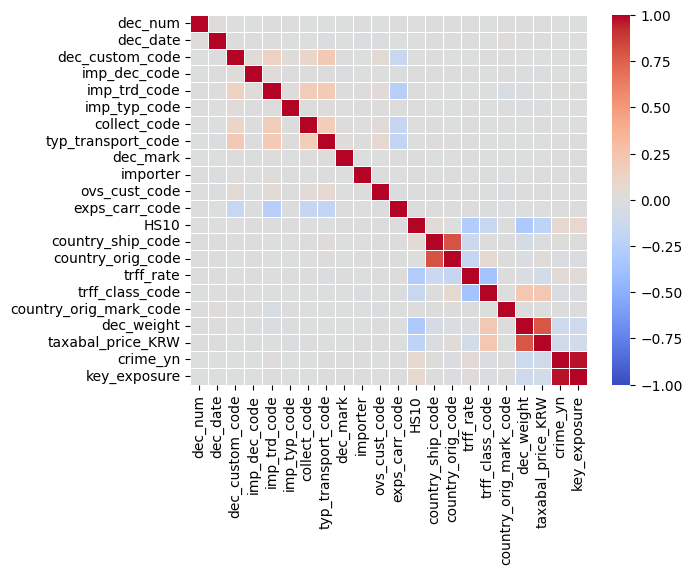

In [ ]:
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths =0.5, annot_kws={'size':10, 'fontproperties':fontprop},vmin=-1.0)

## Random data sampling 
- Extract training data from the given data.
- 1600 is a good size for the data in this exercise.  If the sample size is too large, the processing time increases greatly.

In [ ]:
df_sample=df_org.sample(1600,replace=False)

## Processing Sample Data

- Preserve correlation by grouping well-correlated columns into a single multi-column
- Correlation may not be preserved during data generation

In [ ]:
cols = ['HS10', 'country_ship_code', 'country_orig_code', 'trff_rate', 'trff_class_code', 'dec_weight','taxabal_price_KRW','crime_yn', 'key_exposure']
df_sample['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'] = df_sample[cols].apply(lambda row: '^'.join(row.values.astype(str)), axis=1)

### Delete Unnecessary Columns
- Delete duplicate columns
- 'dec_date' data type causes errors in some Colab environments, so we will delete this column. (Since it has little relation to high risk goods, it will not have huge impact on training.)
- 'dec_num' has no relationship to high risk goods, so we will delete this column.

In [ ]:
df_sample=df_sample.drop(cols, axis=1)
df_sample=df_sample.drop('dec_date', axis=1)
df_sample=df_sample.drop('dec_num', axis=1)

## Training Model with CTGAN 

- Let's train the model using CTGAN algorithm.

In [ ]:
# Declare the list of categories to be trained as a vairable
categorical_columns =[ 'dec_custom_code','imp_dec_code','imp_trd_code',\
                      'imp_typ_code','collect_code', 'typ_transport_code','dec_mark','importer',\
                      'ovs_cust_code','exps_carr_code','country_orig_mark_code','HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key']

- Model training will take less than 10 to 15 minutes.
- If the execution time is too long, please check if the runtime type is selected as GPU.

In [ ]:
# Train CTGAN Model
ctgan = CTGAN(verbose=True)
startTime = time.time()
ctgan.fit(df_sample, categorical_columns, epochs = 500)
endTime = time.time()

print('time:', endTime - startTime )

Epoch 1, Loss G:  4.0529,Loss D: -0.0446
Epoch 2, Loss G:  3.8302,Loss D: -0.1662
Epoch 3, Loss G:  3.8668,Loss D: -0.2718
Epoch 4, Loss G:  3.8313,Loss D: -0.3797
Epoch 5, Loss G:  3.8721,Loss D: -0.4814
Epoch 6, Loss G:  3.9384,Loss D: -0.6265
Epoch 7, Loss G:  3.9067,Loss D: -0.6755
Epoch 8, Loss G:  3.8856,Loss D: -0.7786
Epoch 9, Loss G:  3.9067,Loss D: -0.9422
Epoch 10, Loss G:  4.0502,Loss D: -0.9930
Epoch 11, Loss G:  3.9877,Loss D: -1.0948
Epoch 12, Loss G:  4.0129,Loss D: -1.1437
Epoch 13, Loss G:  3.6593,Loss D: -1.0404
Epoch 14, Loss G:  3.7179,Loss D: -0.8698
Epoch 15, Loss G:  3.6036,Loss D: -0.7104
Epoch 16, Loss G:  3.5609,Loss D: -0.6895
Epoch 17, Loss G:  3.1282,Loss D: -0.6571
Epoch 18, Loss G:  3.1516,Loss D: -0.4247
Epoch 19, Loss G:  2.8570,Loss D: -0.3570
Epoch 20, Loss G:  3.3107,Loss D: -0.2340
Epoch 21, Loss G:  2.7722,Loss D: -0.2734
Epoch 22, Loss G:  2.7709,Loss D: -0.0441
Epoch 23, Loss G:  2.8580,Loss D:  0.0292
Epoch 24, Loss G:  2.7910,Loss D:  0.0920
E

## Generating Synthetic Data with Trained Model

- Generate data with same count as sampled data.
- If we generate more data, we will gradually lose statistical similarity between two tables including correlation.

In [ ]:
# Generate data with same count as sampled data
df_syn = ctgan.sample(len(df_sample))

## Save the New Data
- Check the information of the generated synthetic data.

In [ ]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   dec_custom_code                                       1600 non-null   int64 
 1   imp_dec_code                                          1600 non-null   object
 2   imp_trd_code                                          1600 non-null   int64 
 3   imp_typ_code                                          1600 non-null   int64 
 4   collect_code                                          1600 non-null   int64 
 5   typ_transport_code                                    1600 non-null   int64 
 6   dec_mark                                              1600 non-null   object
 7   importer                                              1600 non-null   object
 8   ovs_cust_code                                         1449 non-null 

- Create individual columns from the combined multi-column data.

In [ ]:
df_syn['HS10']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[0]
df_syn['country_ship_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[1]
df_syn['country_orig_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[2]
df_syn['trff_rate']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[3]
df_syn['trff_class_code']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[4]
df_syn['dec_weight']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[5]
df_syn['taxabal_price_KRW']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[6]
df_syn['crime_yn']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[7]
df_syn['key_exposure']=df_syn.HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key.str.split('^').str[8]

- Delete the combined multi-column.

In [ ]:
df_syn = df_syn.drop(['HS10_ship_orig_tffrt_tffcd_weight_taxprice_crime_key'],axis=1)

### Sort Columns Identical to the Original Data
- Since we combined multiple columns and then separated them, the ordering is mixed up.
- To easily compare with the original data, we re-order the columns.

In [ ]:
# Extract the columns in order, and assign to temporary dataframe.
df_tmp = df_syn[['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure']]
# Delete extracted column from the dataframe that contains synthetic data.
df_syn = df_syn.drop(['HS10','country_ship_code','country_orig_code','trff_rate',\
                 'trff_class_code','country_orig_mark_code','dec_weight','taxabal_price_KRW','crime_yn','key_exposure'],axis=1)
# Using concat function, concatenate temporary dataframe to existing dataframe.
df_syn = pd.concat([df_syn, df_tmp], axis = 1)

NameError: name 'df_syn' is not defined

- Check the information of the synthetic data.

In [ ]:
df_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   dec_custom_code         1600 non-null   int64 
 1   imp_dec_code            1600 non-null   object
 2   imp_trd_code            1600 non-null   int64 
 3   imp_typ_code            1600 non-null   int64 
 4   collect_code            1600 non-null   int64 
 5   typ_transport_code      1600 non-null   int64 
 6   dec_mark                1600 non-null   object
 7   importer                1600 non-null   object
 8   ovs_cust_code           1449 non-null   object
 9   exps_carr_code          473 non-null    object
 10  HS10                    1600 non-null   object
 11  country_ship_code       1600 non-null   object
 12  country_orig_code       1600 non-null   object
 13  trff_rate               1600 non-null   object
 14  trff_class_code         1600 non-null   object
 15  coun

- Finally, save the data to the specified path.

In [ ]:
# Save the data to the specified path.
df_syn.to_csv('./data_sample/df_syn_en_14.csv', index=False, encoding='utf-8-sig')